In [38]:
import numpy as np
import os
os.chdir('c:\\Users\\luism\\Documents\\projects\\bayesian_learning_for_partially_observable_systemss\\iPMCMC\\ipmcmc')
display(os.getcwd())


'c:\\Users\\luism\\Documents\\projects\\bayesian_learning_for_partially_observable_systemss\\iPMCMC\\ipmcmc'

# Context
$$ x_i $$ 

## Linear Gaussian State Space Model

In [77]:
%run generate_data.py
# 4.1. Linear Gaussian State Space Model
from scipy.spatial.transform import Rotation as R
np.random.seed(420)

# Parameters
r = R.from_rotvec(np.array([7*np.pi/10, 3*np.pi/10, np.pi/20]))
rotation_matrix = r.as_dcm()
scaling_matrix = 0.99*np.eye(3)
beta = np.random.dirichlet(np.ones(20)*0.2, 3).transpose()
alpha = scaling_matrix@rotation_matrix
t_max = 50
mu = np.array([0, 1, 1])
start_var = 0.1*np.eye(3)
omega = np.eye(3)
sigma = 0.1*np.eye(20)

# If we want to change the parameters
assert np.all(np.linalg.eigvals(start_var) > 0)
assert np.all(np.linalg.eigvals(omega) > 0)
assert np.all(np.linalg.eigvals(sigma) > 0)

l_states, l_observations = linear_gaussian_state_space(t_max=t_max, mu=mu, start_var=start_var, transition_var=omega, noise_var=sigma, transition_coeffs=alpha, observation_coeffs=beta)
display((l_states.shape, l_observations.shape))

((50, 3), (50, 20))

 ## Nonlinear State Space Model

In [80]:
# 4.2. Nonlinear State Space Model
np.random.seed(420)
t_max = 100000
mu = 0
start_std = np.sqrt(5)
omega = np.sqrt(10)
sigma = np.sqrt(10)

nl_states, nl_observations = nonlinear_gaussian_state_space(t_max=t_max, mu=mu, start_std=start_std, transition_std=omega, noise_std=sigma)

display((nl_states.shape, nl_observations.shape))

((100000,), (100000,))

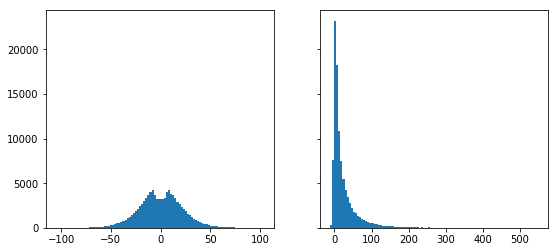

In [84]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 4), sharey=True)
ax1.hist(nl_states, bins=100)
ax2.hist(nl_observations, bins=100)
plt.show()

In [47]:
states.shape, observations.shape

((50, 3), (50, 20))

# Sequential Monte Carlo
 